# Detecção de Raças de Cachorros utilizando Redes Neurais

## Importações

### Importando biblioteca

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
import os 
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


### Importando Dataset

In [15]:
folder_path = "C:\\Users\\amand\\Downloads\\low-resolution\\low-resolution"

list_images = []

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            
            file_path = os.path.join(subfolder_path, file)
            image_about = {}
            breed = subfolder.split("-")[-1]
            image_about["breed"] = breed
            image_about["filename"] = file
            image_about["path_file"] = file_path
            list_images.append(image_about)

df_images = pd.DataFrame.from_records(list_images)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\amand\\Downloads\\low-resolution\\low-resolution'

In [ ]:
df_images

,breed,filename,path_file
0,Shiba_Dog,n100001.jpeg,C:\Users\amand\Downloads\low-resolution\low-re...
1,Shiba_Dog,n100002.jpeg,C:\Users\amand\Downloads\low-resolution\low-re...
2,Shiba_Dog,n100003.jpeg,C:\Users\amand\Downloads\low-resolution\low-re...
3,Shiba_Dog,n100004.jpg,C:\Users\amand\Downloads\low-resolution\low-re...
4,Shiba_Dog,n100005.jpg,C:\Users\amand\Downloads\low-resolution\low-re...
...,...,...,...
70427,papillon,n170756.jpeg,C:\Users\amand\Downloads\low-resolution\low-re...
70428,papillon,n170757.jpeg,C:\Users\amand\Downloads\low-resolution\low-re...
70429,papillon,n170758.jpeg,C:\Users\amand\Downloads\low-resolution\low-re...
70430,papillon,n170759.jpeg,C:\Users\amand\Downloads\low-resolution\low-re...


### Análise Exploratória de Dados

In [ ]:
# counting images number of each breed of dog

# 130 breeds

df2 = df_images.groupby(['breed'])['breed'].count()

df2

breed
Afghan_hound                       222
African_hunting_dog                211
Airedale                           200
American_Staffordshire_terrier     216
Appenzeller                        234
                                  ... 
toy_poodle                        2925
toy_terrier                        237
vizsla                             210
whippet                            234
wire_haired_fox_terrier            226
Name: breed, Length: 130, dtype: int64

#### Visualizando imagens

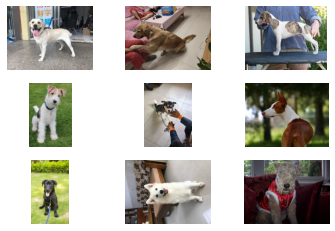

In [ ]:
df = df_images.sample(n=9)
count = 0

for index, row in df.iterrows():
    image = Image.open(row["path_file"])

    # Exibir a imagem
    plt.subplot(3, 3, count + 1)
    plt.imshow(image)
    plt.axis('off')
    count += 1


### Pré-processamento de imagens

In [ ]:
img_size_height = 300
img_size_width = 400

images_binary = np.zeros((len(df_images), img_size_height, img_size_width, 3), dtype='float32')

for i, row in df_images.iterrows():
    #Lê um arquivo de imagem e converte para formato numérico
    #redimensiona todas as imagens para 300x400
    img = cv2.resize(cv2.imread(row["path_file"],cv2.IMREAD_COLOR),((img_size_height,img_size_width)))
    #np.array(img[...,::-1].astype(np.float32)).copy(): Cria uma cópia do array da imagem convertida.
    #np.expand_dims(...): Adiciona uma dimensão extra ao array da imagem, transformando-o em um array de forma (1, altura, largura, canais).
    #preprocess_input(...): Realiza um pré-processamento adicional na imagem, como normalização de valores de pixels ou transformações específicas do modelo.
    img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
    images_binary[i] = img_array

MemoryError: Unable to allocate 94.5 GiB for an array with shape (70432, 300, 400, 3) and data type float32